# Introduction
This notebook walks through the fiducial registration process for just a single US/MPM image pair, and using the functions transferred to the multicscale-imaging package.

In [55]:
# Import basic moduless
from pathlib import Path
import numpy as np
import SimpleITK as sitk
%matplotlib notebook
import matplotlib.pyplot as plt
import tiffile as tif
import pickle
import os

In [56]:
# These modules all come from the multiscale-imaging package: https://github.com/uw-loci/multiscale
import multiscale.LINK_system.coordinate as coord
import multiscale.itk.transform as tran
import multiscale.itk.itk_plotting as iplt
import multiscale.itk.registration as reg
import multiscale.microscopy.ome as ome

In [3]:
fiducial_dir = Path(r'F:\Research\LINK\Mouse images\2019-09-28 Mouse 1596\L22 fiducial')

mpm_tile_path = Path(fiducial_dir, r'L22 fiducial 2 _ deg5 _ kal1 _ scan 02 _ zoom1_1_MMStack_1-Pos_000_000.ome.tif')
mpm_path = Path(fiducial_dir, r'L22 fiducial _ down8x.tif')

us_path = Path(fiducial_dir, r'L22 fiducial 14-182_Run-1.tif')
us_pl_path = Path(fiducial_dir, 'L22 fiducial 14-182.pos')
us_param_path = Path(fiducial_dir, r'L22 fiducial 14-182_Run-1_Settings.mat')
us_height = 14182
dynamic_range = 50

Open the images

In [4]:
mpm_image = coord.open_microscopy(mpm_path, mpm_tile_path, downsample_factor=8)

In [5]:
us_spacing = [18.4802, 18.4802, 18.4802]
us_image = coord.open_us(us_path, us_pl_path, us_param_path, us_spacing, dynamic_range, us_height)

Acquire similar points between images

<IPython.core.display.Javascript object>


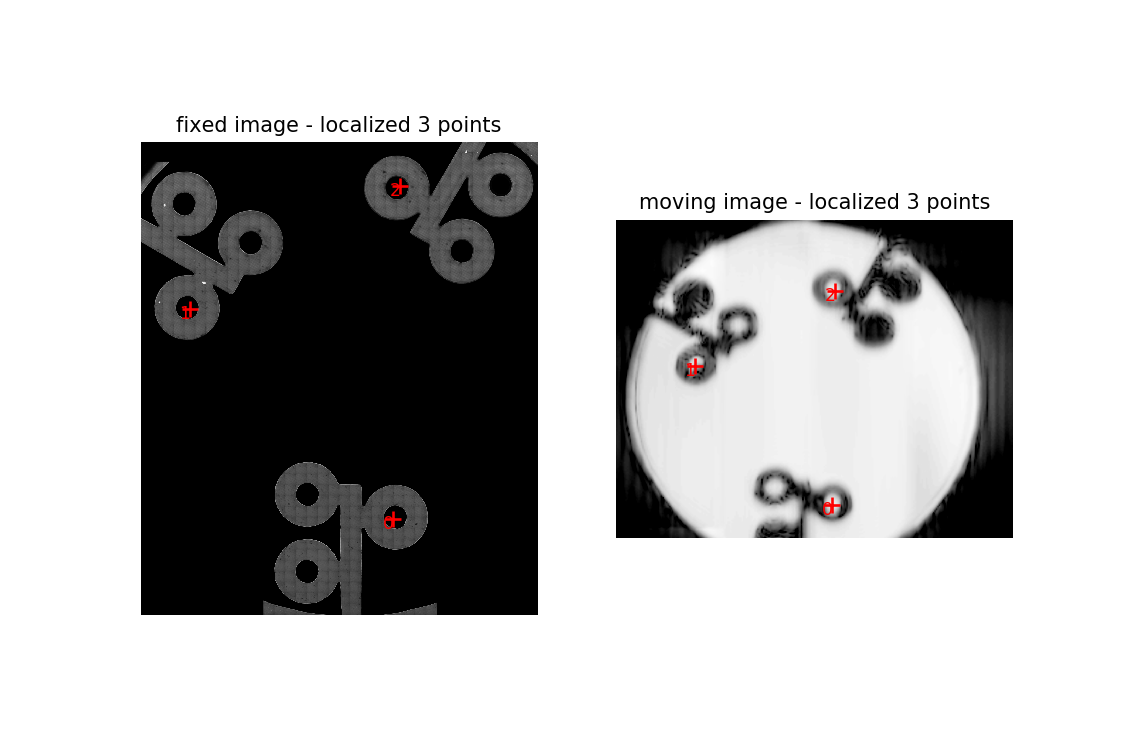

In [6]:
points = iplt.RegistrationPointDataAcquisition(mpm_image, us_image)

In [7]:
fixed_points, moving_points = points.get_points_flat()

Register the images

In [8]:
initial_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), fixed_points, moving_points)
final_transform, metric, stop = reg.register(mpm_image, us_image, initial_transform=initial_transform)
final_params = final_transform.GetParameters()

In [9]:
centroid, labeled_img = coord.calculate_centroid(us_image[:, :, 80:225], radius=True, output_label_img=True)

Threshold used: 50.0


Box(children=(IntSlider(value=72, description='image slice:', max=144),))

<IPython.core.display.Javascript object>


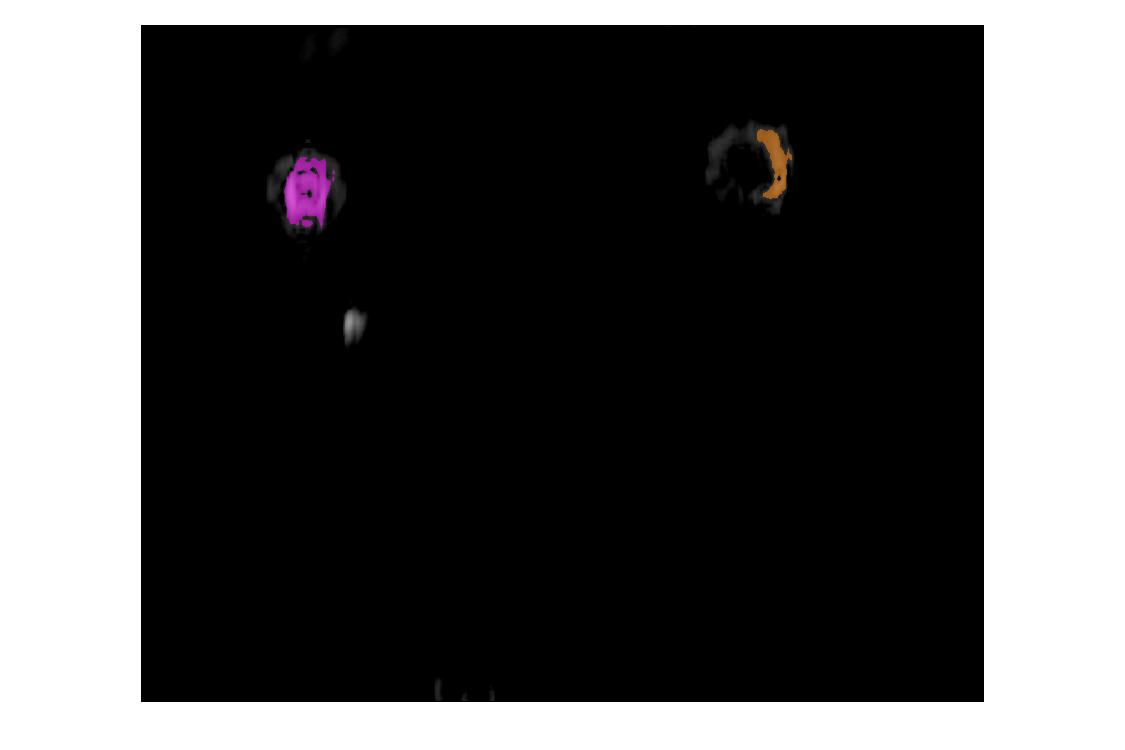

In [10]:
iplt.MultiImageDisplay([sitk.LabelOverlay(us_image[:, :, 80:225], labeled_img)])

In [ ]:
no_radius = coord.calculate_centroid(us_image[:, :, 40:120], radius=False)

In [29]:
centroid

array([23317.48577416, 23344.78296653, 23318.38135592, 23257.02104918,
       23308.19887133, 22167.44694238, 23227.82546185, 23174.46608795])

In [ ]:
np.mean(no_radius) - np.mean(centroid)

In [52]:
fiducial_bottom = np.mean(centroid)

z_translation = fiducial_bottom - (mpm_image.GetOrigin()[2] - 170)

In [53]:
coordinate_transform = np.array(final_params)
coordinate_transform[5] = z_translation
print('Final coordinate transform: {}'.format(coordinate_transform))

Final coordinate transform: [-1.88548469e-03  7.69066638e-04 -2.50053207e-04  8.19993985e+02
  4.57660935e+03  2.42344511e+04]


In [54]:
# Save the results
coordinate_path = Path(fiducial_dir, 'L22 Transform.txt')
with open(coordinate_path, 'wb') as fp:
    pickle.dump(coordinate_transform, fp)

In [14]:
registered_dir = Path(fiducial_dir, 'Registered')

In [ ]:
mpm_reg_path = Path(registered_dir, 'MPM Reg to US.tif')

In [ ]:
mpm_reg = tran.apply_transform_params(us_image, mpm_image, 
                                     -1*coordinate_transform,
                                     sitk.VersorRigid3DTransform())

In [ ]:
sitk.WriteImage(mpm_reg, str(mpm_reg_path))

In [16]:
# Index 0 is no shift, index 1 is 1mm, 2 is 2mm, 3 is 3mm.
height_transforms = [coordinate_transform.copy() for idx in range(4)]
for idx in range(4):
    height_transforms[idx][5] = coordinate_transform[5] - 1000*idx

In [17]:
mpm_reg = [tran.apply_transform_params(us_image, mpm_image, -1*height_transforms[idx], sitk.VersorRigid3DTransform()) for idx in range(4)]
# for idx in range(4):
#     reg_path = Path(registered_dir, 'MPM Height Reg {}mm.tif'.format(idx))
#     sitk.WriteImage(mpm_reg[idx], str(reg_path))

In [18]:
# Add together the MPM images at all 4 locations to show them in the US volume.
mpm_all_reg = mpm_reg[0] + mpm_reg[1] + mpm_reg[2] + mpm_reg[3]
reg_path = Path(registered_dir, 'MPM Height All Reg - radius.tif')
# sitk.WriteImage(mpm_all_reg, str(reg_path))

Box(children=(IntSlider(value=162, description='image slice:', max=324),))

<IPython.core.display.Javascript object>


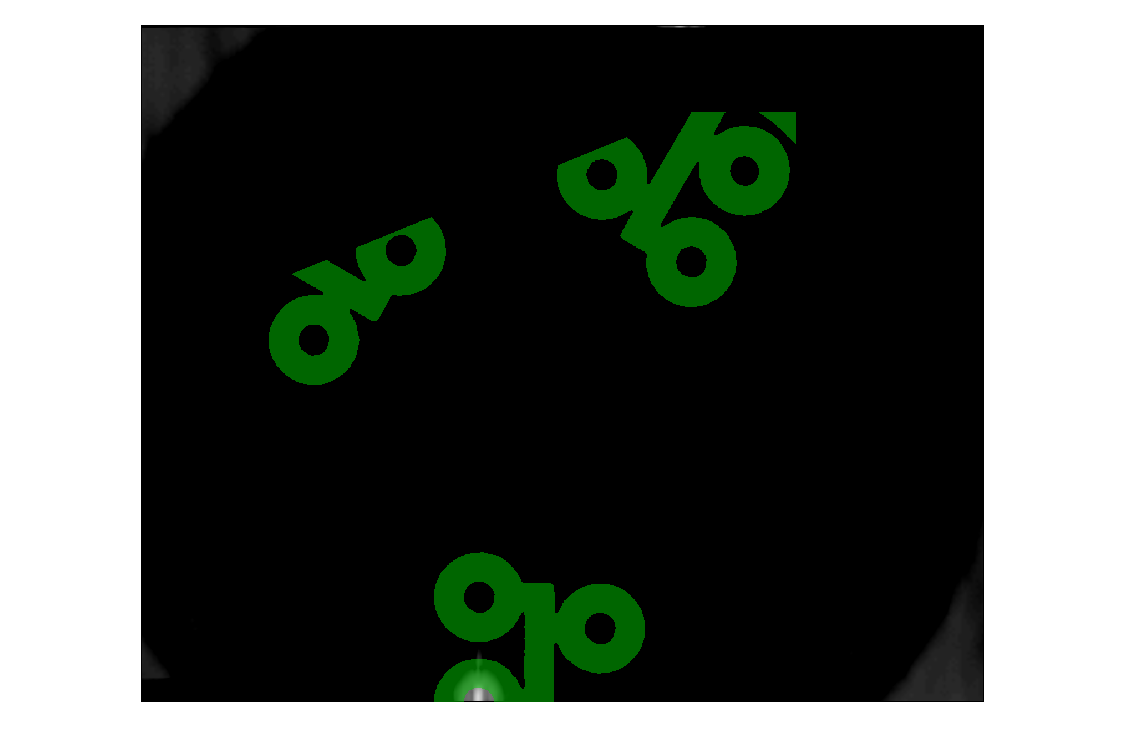

In [23]:
mpm_binary = mpm_all_reg > 10
iplt.MultiImageDisplay([sitk.LabelOverlay(us_image, mpm_binary)])

In [ ]:
us_path = Path(registered_dir, 'US rotated.tif')
sitk.WriteImage(us_image, str(us_path))